In [2]:
import os
os.chdir('../../')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 

In [3]:
## Load in datasets, note we will train on the 'clean_data_all' dataset which contains many more matches 

df_train = pd.read_csv('data/clean/clean_data_all.csv', index_col=False) ## Use large dataset to train nn

df_train['team1'] = df_train['team1'].map(lambda l: l.replace(' ', ''))
df_train['team2'] = df_train['team2'].map(lambda l: l.replace(' ', ''))

df_test = pd.read_csv('data/clean/clean_data_test.csv', index_col=False)

In [4]:
df_train.head()


,team1,team1score,team2,team2score,match_type,match_stage,player0_id,player0_rating,player0_kd,player1_id,...,player7_kd,player8_id,player8_rating,player8_kd,player9_id,player9_rating,player9_kd,team1_Ranking,team2_Ranking,team_1_won
0,GUILDfe,2,FearlessCheetahs,1,BO3,NaN,15831.0,1.13,1.04,22104.0,...,1.09,10285.0,1.01,0.91,18781.0,1.01,0.96,262.0,223.0,1
1,FearlessCheetahs,1,BIGEQUIPA,2,BO3,SF,1572.0,1.13,0.96,17214.0,...,1.03,22871.0,1.11,1.08,7653.0,1.02,0.92,223.0,210.0,0
2,1WINGang,1,FearlessCheetahs,2,BO3,G,22092.0,1.15,1.05,18773.0,...,1.14,10285.0,1.07,0.97,18781.0,1.02,0.98,272.0,223.0,0
3,ENCEAthena,2,AstralisW,1,BO3,G,22604.0,1.20,1.16,23050.0,...,0.87,13786.0,0.89,0.81,22094.0,0.84,0.73,228.0,252.0,1
4,NAVIJavelins,2,VP.Angels,0,BO3,G,22062.0,1.27,1.30,22063.0,...,0.91,23440.0,0.97,0.86,22934.0,0.87,0.75,200.0,244.0,1


In [5]:
### We will create embeddings for team Name and Player ID
team_name_list = pd.concat([df_train['team1'], df_train['team2'], df_test['team1'], df_test['team2']]).unique()

player_id_list = pd.concat([pd.concat([df_train[f'player{i}_id'], df_test[f'player{i}_id']]) for i in range(10)]).unique()


In [6]:
from sklearn.preprocessing import LabelEncoder

## Creates encoding for team names
team_name_enc = LabelEncoder()
team_name_enc.fit(team_name_list)
df_train['team1'] = team_name_enc.transform(df_train['team1'])
df_train['team2'] = team_name_enc.transform(df_train['team2'])

## Creates encodings for player ids
player_enc = LabelEncoder()
player_enc.fit(player_id_list)
for i in range(10):
    df_train[f'player{i}_id'] = player_enc.transform(df_train[f'player{i}_id'])

## Creates encoding for match types
mt_enc = LabelEncoder()
mt_enc.fit(df_train['match_type'])
df_train['match_type'] = mt_enc.transform(df_train['match_type'])

## Creates encodings for match stage
ms_enc = LabelEncoder()
ms_enc.fit(df_train['match_stage'])
df_train['match_stage'] = ms_enc.transform(df_train['match_stage'])

In [7]:
## Gets numerical features
numerical_features = ['team1_Ranking', 'team2_Ranking']
for i in range(10):
    numerical_features.append(f'player{i}_rating')
    numerical_features.append(f'player{i}_kd')

## Gets text features
text_features = ['team1', 'team2', 'match_type', 'match_stage']
for i in range(10):
    text_features.append(f'player{i}_id')

## Split train data into its numerical and text parts
X_numerical = df_train[numerical_features]

X_text = df_train[text_features]

y = df_train['team_1_won']

In [8]:
from sklearn.model_selection import train_test_split

## Split train data into train and validation
X_text_train, X_text_val, X_numerical_train, X_numerical_val, y_train, y_val = train_test_split(X_text, X_numerical, y, test_size=0.2, random_state=42)

## Get lists of the text datatset - This is required for the model input
X_text_train_list = []
for text_feat in text_features:
    X_text_train_list.append(X_text_train[text_feat])

X_text_val_list = []
for text_feat in text_features:
    X_text_val_list.append(X_text_val[text_feat])

In [9]:
X_text_train

,team1,team2,match_type,match_stage,player0_id,player1_id,player2_id,player3_id,player4_id,player5_id,player6_id,player7_id,player8_id,player9_id
1080,213,27,1,2,894,984,802,664,291,407,832,433,1288,166
485,14,263,1,1,1057,382,265,1304,932,913,1261,911,1146,321
2179,40,268,1,2,758,795,206,699,42,803,792,1317,668,23
3307,73,88,1,3,243,715,746,333,427,346,471,312,884,473
1104,220,93,0,4,533,846,990,324,672,1328,440,430,784,1013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,297,141,1,0,1100,1089,1484,1292,1254,1286,656,1285,249,87
1294,180,265,1,3,1015,1009,212,642,741,1042,1075,888,590,69
860,14,212,0,4,382,1057,932,1304,265,374,520,489,993,373
3507,221,223,1,4,1147,937,833,225,1188,928,668,435,1038,1012


In [10]:
from tensorflow.keras.layers import Dense, Embedding, BatchNormalization, ReLU, Concatenate, Flatten, Dropout
from tensorflow.keras.regularizers import L1L2, L2
from tensorflow.keras.activations import tanh
from tensorflow.keras import Input, Model

## This function gets a Dense Neural Network that takes as input the numerical dataset
## Each layer consists of a Dense Layer followed by a Batch Normalization and a tanh activation function and then a layer of dropout

def get_model(layers = [64,64,64], rate = 0.5):
    input = Input(shape = (22, ))
    h = Dense(layers[0], kernel_regularizer=L1L2(1e-8, 1e-7), bias_regularizer=L2(1e-7))(input)
    h = BatchNormalization()(h)
    h = tanh(h)
    h = Dropout(rate)(h)
    for layer in layers[1:-2]:
        h = Dense(layer, kernel_regularizer=L1L2(1e-8, 1e-7), bias_regularizer=L2(1e-7))(h)
        h = BatchNormalization()(h)
        h = tanh(h)
        h = Dropout(rate)(h)
    h = Dense(layers[-1], kernel_regularizer=L1L2(1e-8, 1e-7), bias_regularizer=L2(1e-7))(h)
    h = BatchNormalization()(h)
    h = tanh(h)
    h = Dropout(rate)(h)
    output = Dense(1)(h) ## returns logits
    model = Model(inputs = input, outputs = output)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    model.compile(loss = loss, optimizer = 'adam')
    return model

In [15]:
from tensorflow.keras.callbacks import EarlyStopping


callback = EarlyStopping(patience = 200, restore_best_weights = True) ## 100 epoch patience for val loss

model = get_model([4096]*6, rate= 0.2)
history = model.fit(X_numerical_train, y_train, epochs=10000, batch_size=64, validation_data=(X_numerical_val, y_val), verbose=False, callbacks=callback) ## train the model

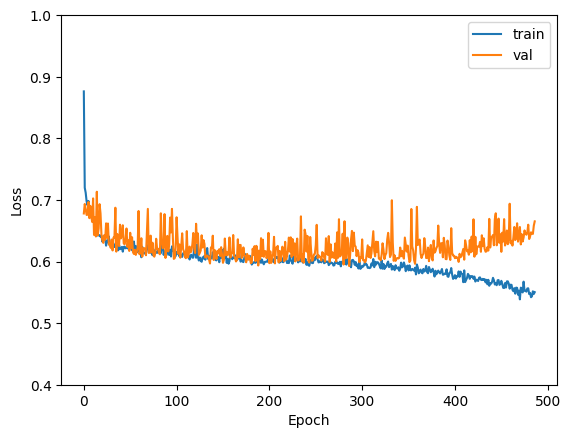

In [16]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'val')
plt.ylim([0.4,1])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

In [17]:
preds = model.predict(X_numerical_val)
print('accuracy is ', np.mean((preds>0).squeeze() == y_val))
logit = np.squeeze(preds)
probs = np.exp(logit)/(1+np.exp(logit))
print('Cross entropy score is ', -np.mean(np.log(probs)*y_val + np.log(1-probs)*(1-y_val)))


24/24 [==============================] - 0s 5ms/step
accuracy is  0.675531914893617
Cross entropy score is  0.5879670569296689


Many different neural networks was tried here with different number of layers and different layer depths, a brief list of some of the things investigated were:
* Number of Layers
* Layer Depths
* ReLU vs tanh activation function
* Batch Norm effectiveness
* Found improved results using kernel regularizers
* regularizer strength
* Introduced Dropout and tested different rates
* Outputting logits vs probabilities

In [23]:
## Prepare test data
## Using the same process as we prepared the train data

df_test['team1'] = df_test['team1'].map(lambda l: l.replace(' ', ''))
df_test['team2'] = df_test['team2'].map(lambda l: l.replace(' ', ''))

df_test['team1'] = team_name_enc.transform(df_test['team1'])
df_test['team2'] = team_name_enc.transform(df_test['team2'])

for i in range(10):
    df_test[f'player{i}_id'] = player_enc.transform(df_test[f'player{i}_id'])

df_test['match_type'] = mt_enc.transform(df_test['match_type'])

df_test['match_stage'] = ms_enc.transform(df_test['match_stage'])

df_num_test = df_test[numerical_features]

df_text_test = df_test[text_features]

y_test = df_test['team_1_won']

In [24]:
### train and test performance for test model

model = get_model([4096]*6, rate= 0.2) ## We choose best hyperparams I found
history = model.fit(X_numerical, y, epochs=400, batch_size=64, verbose=False) ## Train using the full train set


In [25]:
### make predictions for test data
preds = model.predict(df_num_test)
print('accuracy is ', np.mean((preds>0).squeeze() == y_test))
logit = np.squeeze(preds)
probs = np.exp(logit)/(1+np.exp(logit))
print('Cross entropy score is ', -np.mean(np.log(probs)*y_test + np.log(1-probs)*(1-y_test)))

2/2 [==============================] - 0s 2ms/step
accuracy is  0.7058823529411765
Cross entropy score is  0.5993365947814548


In [26]:
## Save model for future predictions
model.save('outputs/models/nn_numeric_input.h5')

In [33]:
## This function gets a  Neural Network that takes as input the numerical dataset and the text dataset
## First we embed all the relevant text data into an embedding space and concatenate these onto the numerical dataset, we then pass to a dense neural network where
## Each layer consists of a Dense Layer followed by a Batch Normalization and a tanh activation function and then a layer of dropout

def get_full_model(embed_dim=32, layer_dims = [64, 64, 64], rate = 0.2):
    team_embedding = Embedding(len(team_name_enc.classes_), embed_dim, embeddings_regularizer = L2(1e-5))
    player_embedding = Embedding(len(player_enc.classes_), embed_dim, embeddings_regularizer = L2(1e-5))
    match_type_embedding = Embedding(len(mt_enc.classes_), embed_dim, embeddings_regularizer = L2(1e-5))
    match_stage_embedding = Embedding(len(ms_enc.classes_), embed_dim, embeddings_regularizer = L2(1e-5))

    ## get inputs for each text feature
    t1 = Input(shape=(1))
    t2 = Input(shape=(1))
    mt = Input(shape=(1))
    ms = Input(shape=(1))
    p0 = Input(shape=(1))
    p1 = Input(shape=(1))
    p2 = Input(shape=(1))
    p3 = Input(shape=(1))
    p4 = Input(shape=(1))
    p5 = Input(shape=(1))
    p6 = Input(shape=(1))
    p7 = Input(shape=(1))
    p8 = Input(shape=(1))
    p9 = Input(shape=(1))

    ## Embed each text feature
    t1_embed = Flatten()(team_embedding(t1))
    t2_embed = Flatten()(team_embedding(t2))
    mt_embed = Flatten()(match_type_embedding(mt))
    ms_embed = Flatten()(match_stage_embedding(ms))
    p0_embed = Flatten()(player_embedding(p0))
    p1_embed = Flatten()(player_embedding(p1))
    p2_embed = Flatten()(player_embedding(p2))
    p3_embed = Flatten()(player_embedding(p3))
    p4_embed = Flatten()(player_embedding(p4))
    p5_embed = Flatten()(player_embedding(p5))
    p6_embed = Flatten()(player_embedding(p6))
    p7_embed = Flatten()(player_embedding(p7))
    p8_embed = Flatten()(player_embedding(p8))
    p9_embed = Flatten()(player_embedding(p9))

    
    numerical_input = Input(shape = (22))

    ## Concatenate all features
    embeddings_concat = Concatenate()([t1_embed, t2_embed, mt_embed, ms_embed, p0_embed, p1_embed, p2_embed, p3_embed, p4_embed, p5_embed, p6_embed, p7_embed, p8_embed, p9_embed, numerical_input])
    # embeddings_concat = Concatenate()([t1_embed, t2_embed, mt_embed, ms_embed, numerical_input])

    h = Dense(layer_dims[0], kernel_regularizer=L1L2(1e-5, 1e-4), bias_regularizer=L2(1e-5))(embeddings_concat)
    h = BatchNormalization()(h)
    h = tanh(h)
    h = Dropout(rate)(h)
    for layer in layer_dims[1:-2]:
        h = Dense(layer, kernel_regularizer=L1L2(1e-5, 1e-4), bias_regularizer=L2(1e-5))(h)
        h = BatchNormalization()(h)
        h = tanh(h) 
        h = Dropout(rate)(h)

    h = Dense(layer_dims[-1], kernel_regularizer=L1L2(1e-5, 1e-4), bias_regularizer=L2(1e-5))(h)
    h = BatchNormalization()(h)
    h = tanh(h)
    h = Dropout(rate)(h)
    output = Dense(1)(h)

    model = Model(inputs = (t1, t2, mt, ms, p0, p1, p2, p3, p4, p5, p6, p7, p8, p9, numerical_input), outputs = output)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    model.compile(loss = loss, optimizer = 'adam')
    return model

In [28]:
model = get_full_model()
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 1)]          0           []                               
                                                                                            

In [37]:
callback = EarlyStopping(patience = 200, restore_best_weights = True) ## 100 epoch patience for val loss

## We need to convert our datasets to a list of the iindivual text features and the numerical features
## As this is the input our NN takes
X_train_concat = [X_text_train_list[i] for i in range(len(text_features))] + [X_numerical_train]
X_val_concat = [X_text_val_list[i] for i in range(len(text_features))] + [X_numerical_val]

model = get_full_model(16, [4069]*6, rate=0.5)
history = model.fit(X_train_concat, y_train, epochs=2500, batch_size=64, validation_data=(X_val_concat, y_val), verbose=False, callbacks= callback)

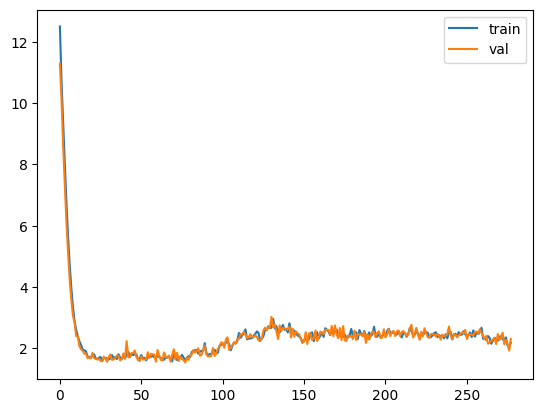

In [38]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'val')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()

In [32]:
preds = model.predict(X_val_concat)

print('accuracy is ', np.mean((preds>0.5).squeeze() == y_val))
binCE_loss = tf.keras.losses.binary_crossentropy(y_val, preds)
logit = np.squeeze(preds)
probs = np.exp(logit)/(1+np.exp(logit))
print('Cross entropy score is ', -np.mean(np.log(probs)*y_val + np.log(1-probs)*(1-y_val)))


24/24 [==============================] - 0s 4ms/step
accuracy is  0.6143617021276596
Cross entropy score is  1.0144907585018565


This network proved very difficult to train and I could not get it to provide improved results over the more simple NN above, hence the simple NN is used for our prediction.

Again, here is a brief list of some of the things investigated were:
* Number of Layers
* Layer Depths
* ReLU vs tanh activation function
* Batch Norm effectiveness
* Found improved results using kernel regularizers
* regularizer strength - Too strong and the model struggles to trrain, too weak and the model overfits and the validation performance is extremely poor
* Introduced Dropout and tested different rates
* Outputting logits vs probabilities

Looking at this loss we see that the model struggles to train at all, I tried many thinsg to try and get results from this model but was ultimately unable to find a good set of hyperparameters. Perhaps the architecture itself is too challenging or not good enough. I believe the embeddings to be important and feel it should be able to capture relationships between these qualitative features, perhaps more should be done with the embeddings before concatenating with the numerical features. This is a model that should be explored further and we hope can improve results.

In [40]:
### train and test performance for test model
X_text_list = []
for text_feat in text_features:
    X_text_list.append(X_text[text_feat])

X_concat = [X_text_list[i] for i in range(len(text_features))] + [X_numerical]


model = get_full_model(16, [4069]*6, rate=0.5)

history = model.fit(X_concat, y, epochs=100, batch_size=64, verbose=False)

In [41]:
X_text_list_for_preds = []
for text_feat in text_features:
    X_text_list_for_preds.append(df_text_test[text_feat])

X_concat_for_pred = [X_text_list_for_preds[i] for i in range(len(text_features))] + [df_num_test]


### make predictions for test data
preds = model.predict(X_concat_for_pred)
print('accuracy is ', np.mean((preds>0).squeeze() == y_test))
logit = np.squeeze(preds)
probs = np.exp(logit)/(1+np.exp(logit))
print('Cross entropy score is ', -np.mean(np.log(probs)*y_test + np.log(1-probs)*(1-y_test)))

2/2 [==============================] - 0s 4ms/step
accuracy is  0.6764705882352942
Cross entropy score is  0.6507424598231035
